In [ ]:
#aggiungi PCA

## Gamma Ray Burst

Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 



In [212]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd
import corner
from scipy.optimize import minimize
from IPython.display import display, Math
import requests
import random
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth
import seaborn as sns 
from IPython.display import Markdown as md

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
def kde_sklearn(data, bandwidth = 1.0, kernel="linear"):
    kde_skl = KernelDensity(bandwidth = bandwidth, 
                            kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)

In [42]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])


In [43]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

## Data exploration

In [81]:
#features I am interested in 
par_keys = ['ra', 'decl', 'pos_error', 'T90', 'T90_error','fluence', 'fluence_error', 'redshift', "'T100'"]

df = pd.DataFrame(data.T, columns=names)
df_subset = df[par_keys].copy()

for col in par_keys:
    df_subset[col] = pd.to_numeric(df_subset[col], errors='coerce')

#select only data with a physical meaning
df_pos = df_subset[(df_subset['T90'] > 0) & (df_subset["'T100'"] > 0) & (df_subset['redshift'] > 0) & (df_subset['fluence'] > 0)]

#I want to create a corner plot but without the errors for now
plot_keys = [key for key in par_keys if '_error' not in key]
plot_data = df_pos[plot_keys].dropna(how='any').to_numpy() #avoid to take rows with NaN data

Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours


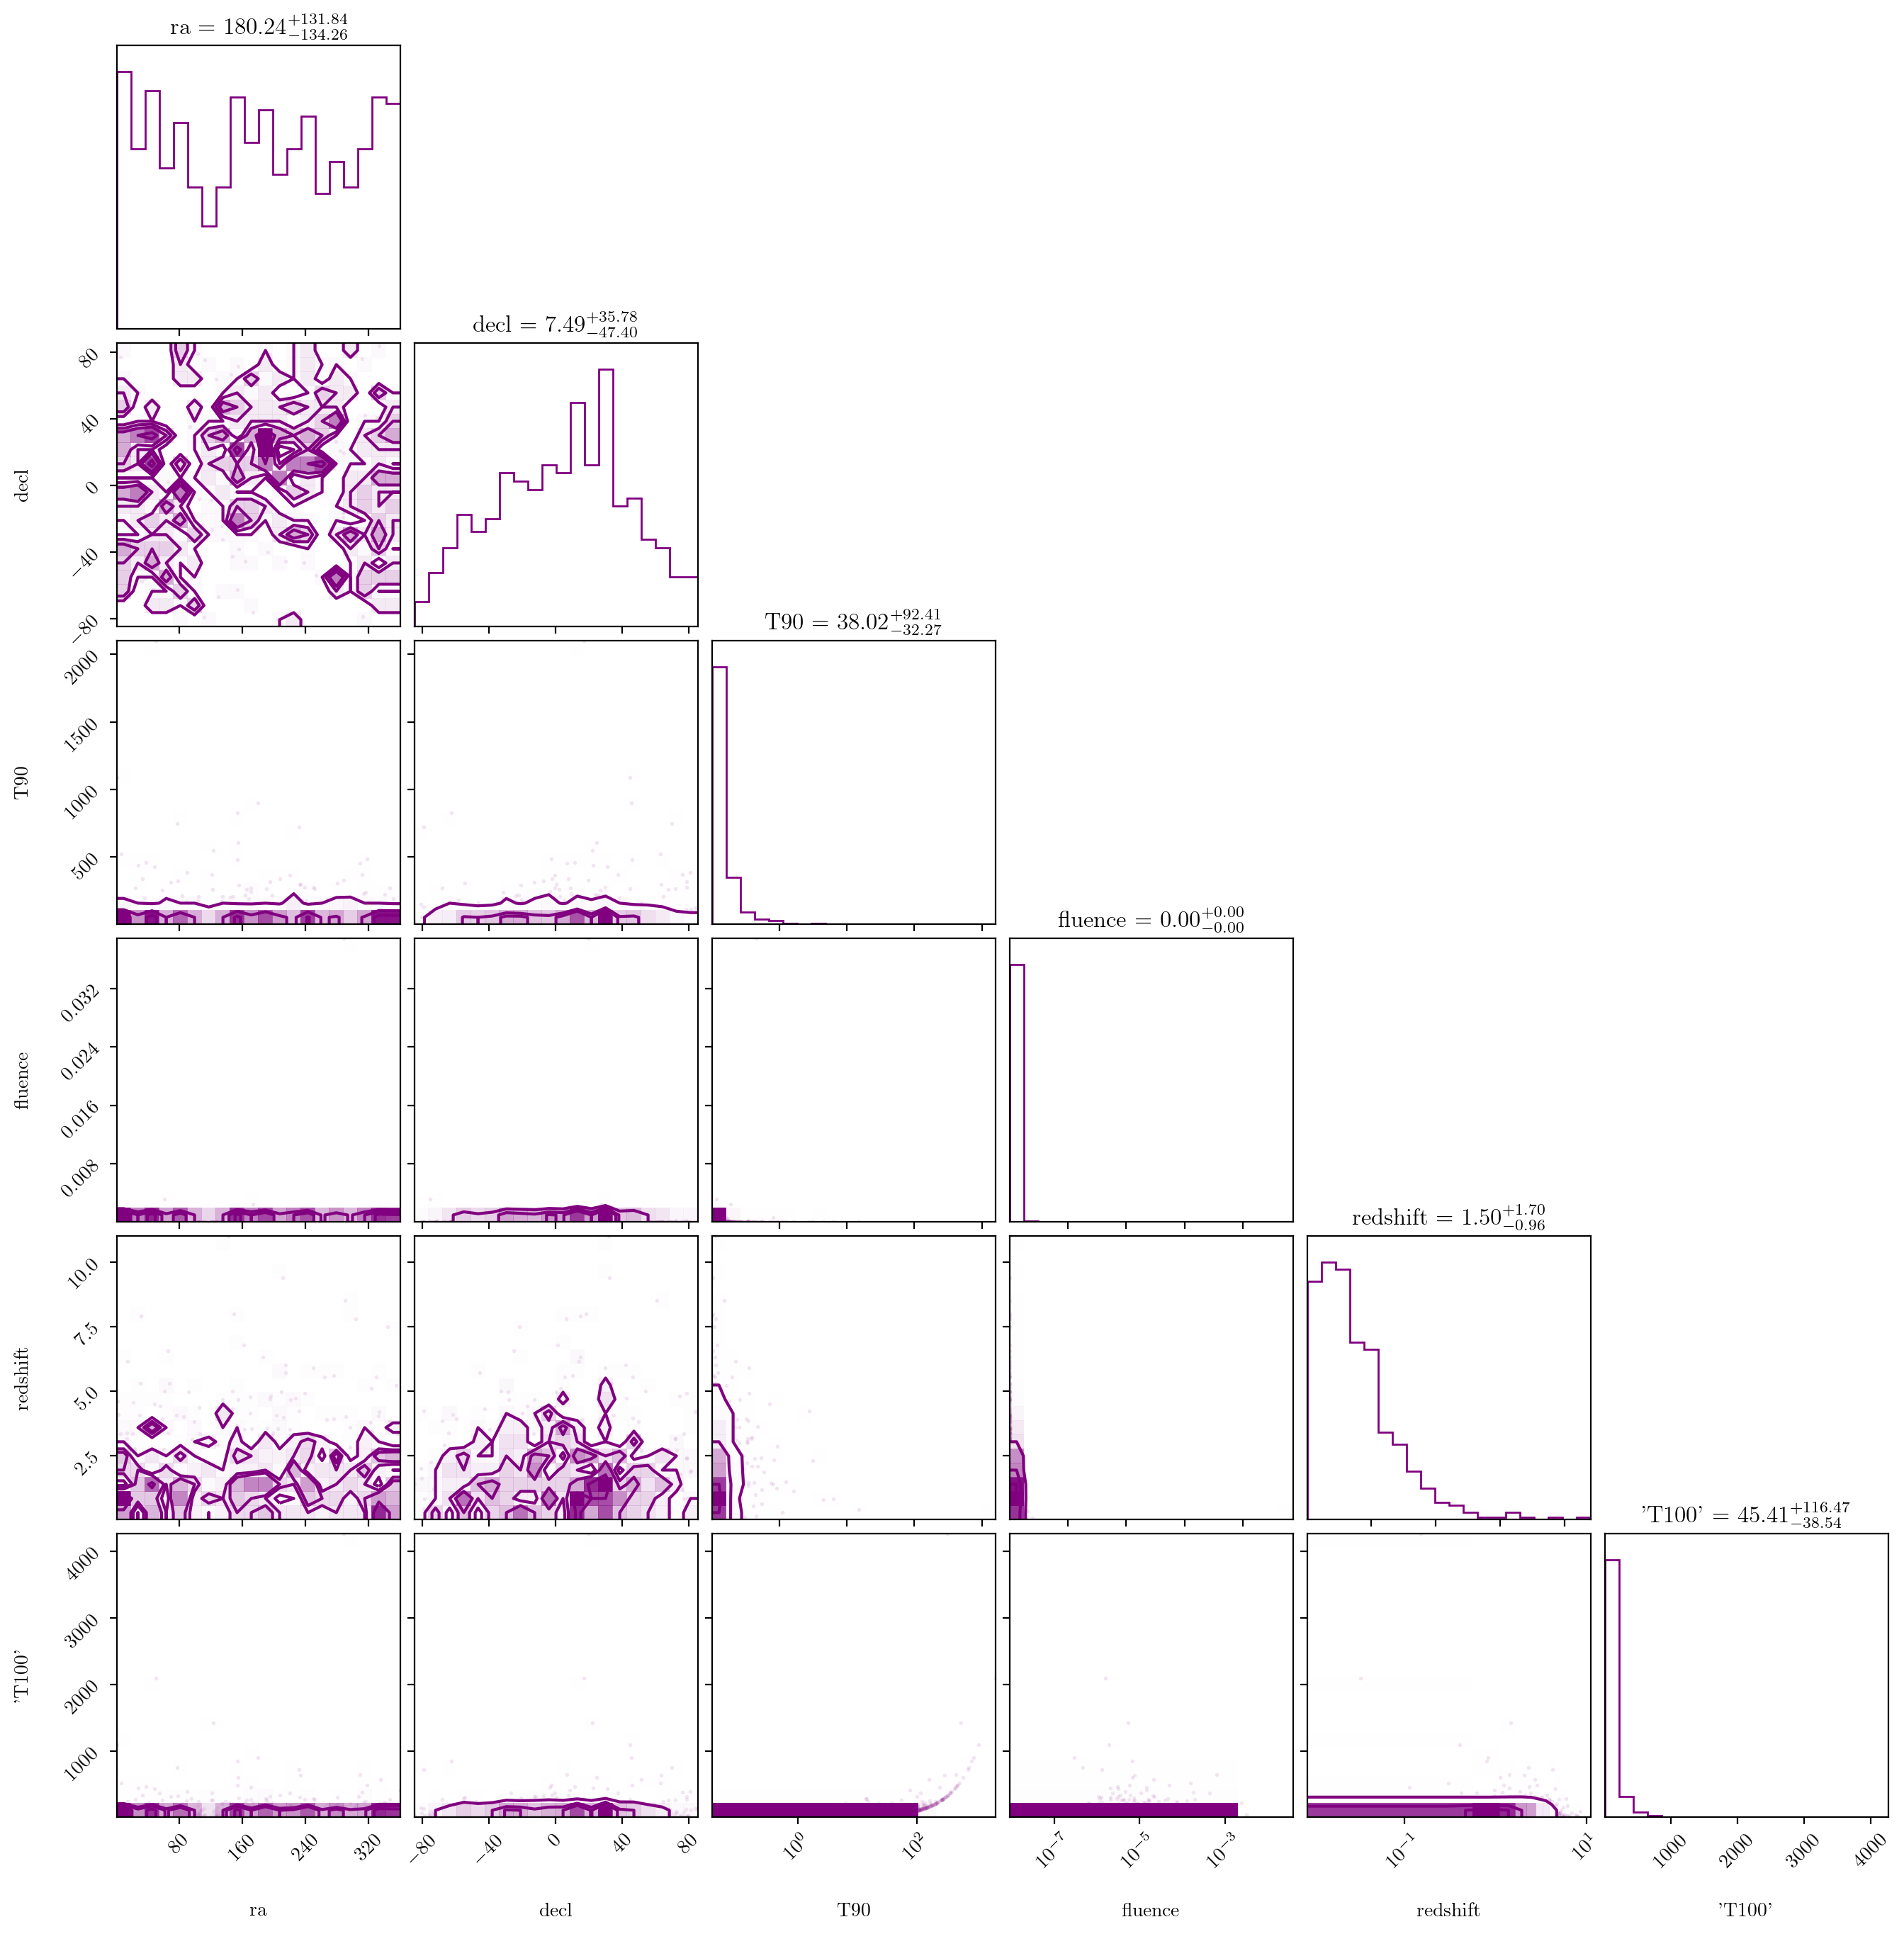

In [82]:
fig = corner.corner(plot_data, labels=plot_keys, show_titles=True, color='purple')

log_scale_keys = ['T90', 'T100', 'redshift', 'fluence']
for ax in fig.get_axes():
    if ax.get_xlabel() in log_scale_keys:
        ax.set_xscale('log')

plt.show()

In [214]:
print(len(plot_data))

574


I have very few data for some of them bc I am deleting all the rows that as al least one of the features with no physical meaning (requiring that time, redshift and fluece should be > 0).
So sometimes the idea of not using all of the features is smart bc for example in this case with all of the data i just have 574 points 

While if for example I consider only the T90 feature

In [215]:
print(len(np.array(df_subset['T90'][(df_subset['T90'] > 0)])))

7470


I have more than 10 times the points

## Histograms of some features

I have the feeling that T90 and T100 gives me the same info abut data

In [90]:
T90 = np.array(df_subset['T90'][(df_subset['T90'] > 0)])
T100 = np.array(df_subset["'T100'"][(df_subset["'T100'"] > 0)])

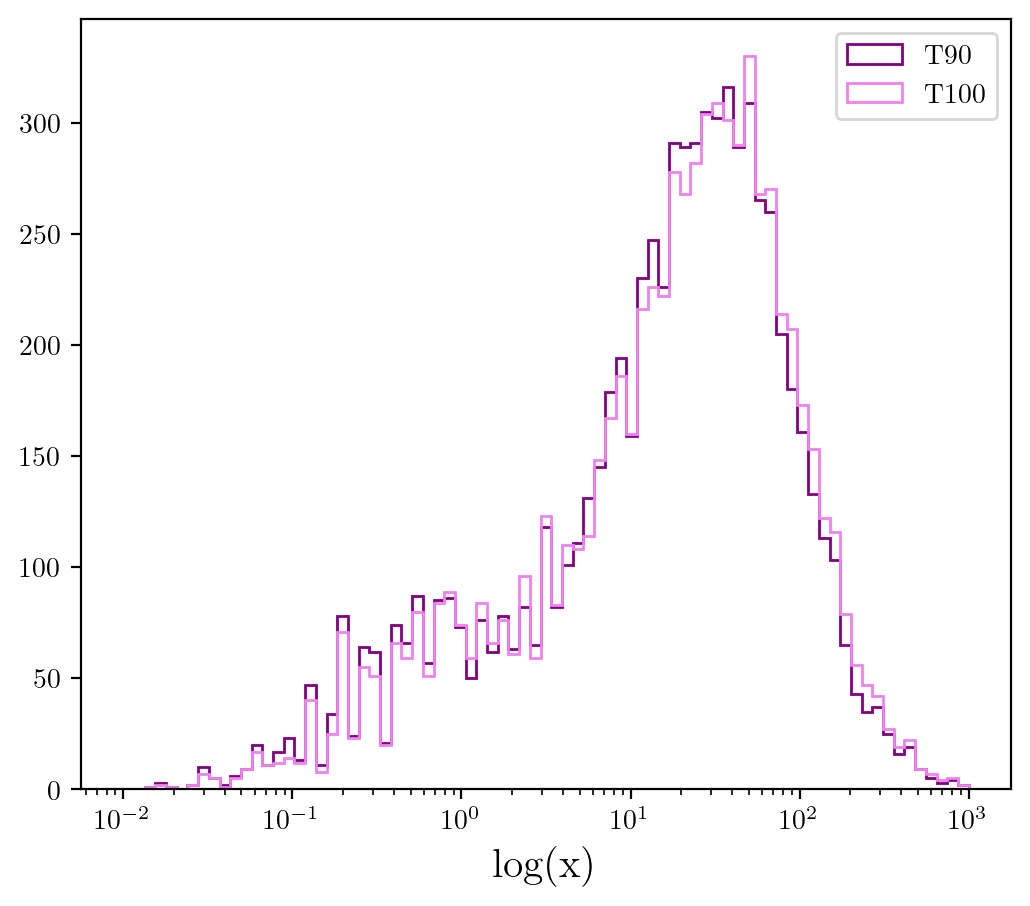

In [91]:
fig = plt.figure(figsize=(6, 5))
plt.hist(T90, bins=np.logspace(-2,3,80), histtype='step', color='purple', label='T90')
plt.hist(T100, bins=np.logspace(-2,3,80), histtype='step', color='violet', label='T100')
plt.xlabel('log(x)',fontsize=15)
plt.xscale('log')
plt.legend()
plt.show()

yes, so I will continue to study only one of them

### KDE with cross validation for choosing bandwidth

Optimal bandwidth: 0.0785


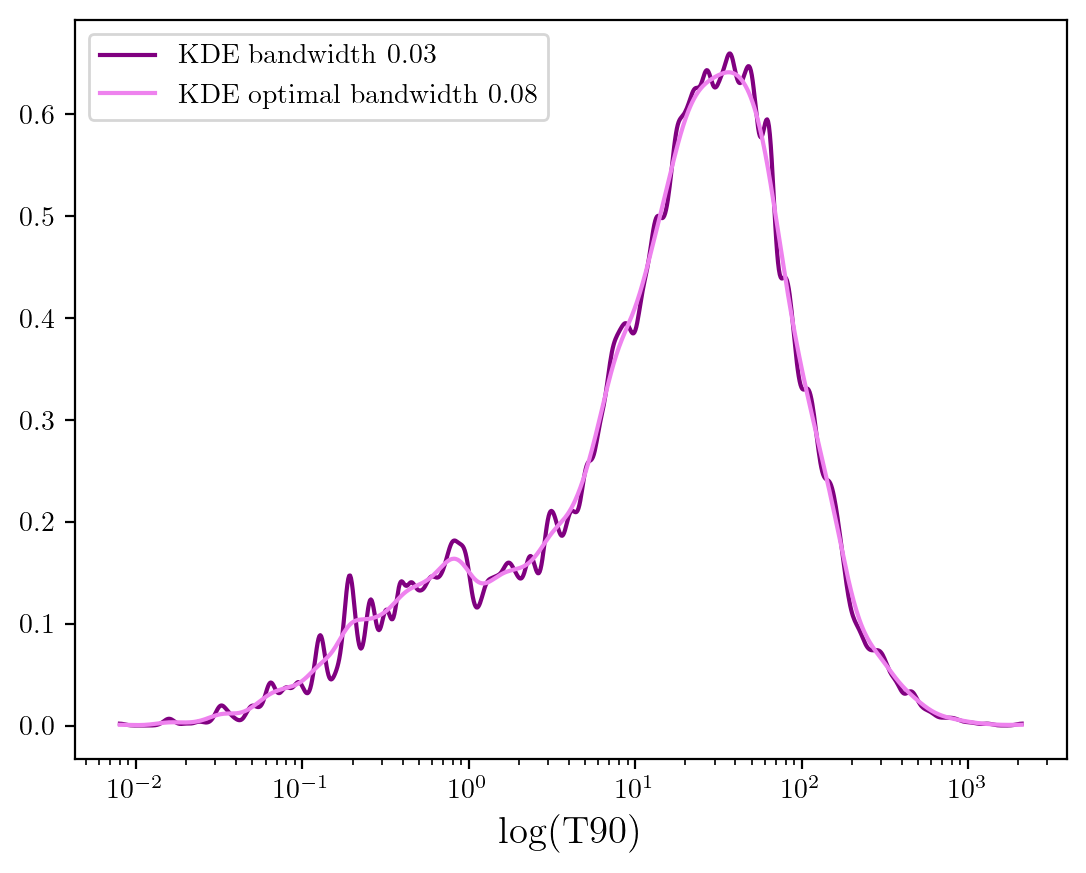

In [197]:
T90_log=np.log10(T90)
bwrange = np.logspace(-3, 3, 20)
K = 5
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K)
grid.fit(T90_log[:, np.newaxis])
w_opt = grid.best_params_['bandwidth']
print(f'Optimal bandwidth: {w_opt:.4f}')

# grid for KDE in log space
xgrid = np.linspace(T90_log.min(), T90_log.max(), 1000)

w = 0.03 #I select manually this bandwidth
PDF_manual = kde_sklearn(T90_log, bandwidth=w, kernel='gaussian')
plt.plot(10**xgrid, PDF_manual, label=f'KDE bandwidth {w}', color='purple')

PDF_opt = kde_sklearn(T90_log, bandwidth=w_opt, kernel='gaussian')
plt.plot(10**xgrid, PDF_opt, label=f'KDE optimal bandwidth {w_opt:.2f}', color='violet')

plt.xscale('log')
plt.xlabel('log(T90)', fontsize=14)

plt.legend()
plt.show()

## K means with 2 clusters for log(T90) histogram

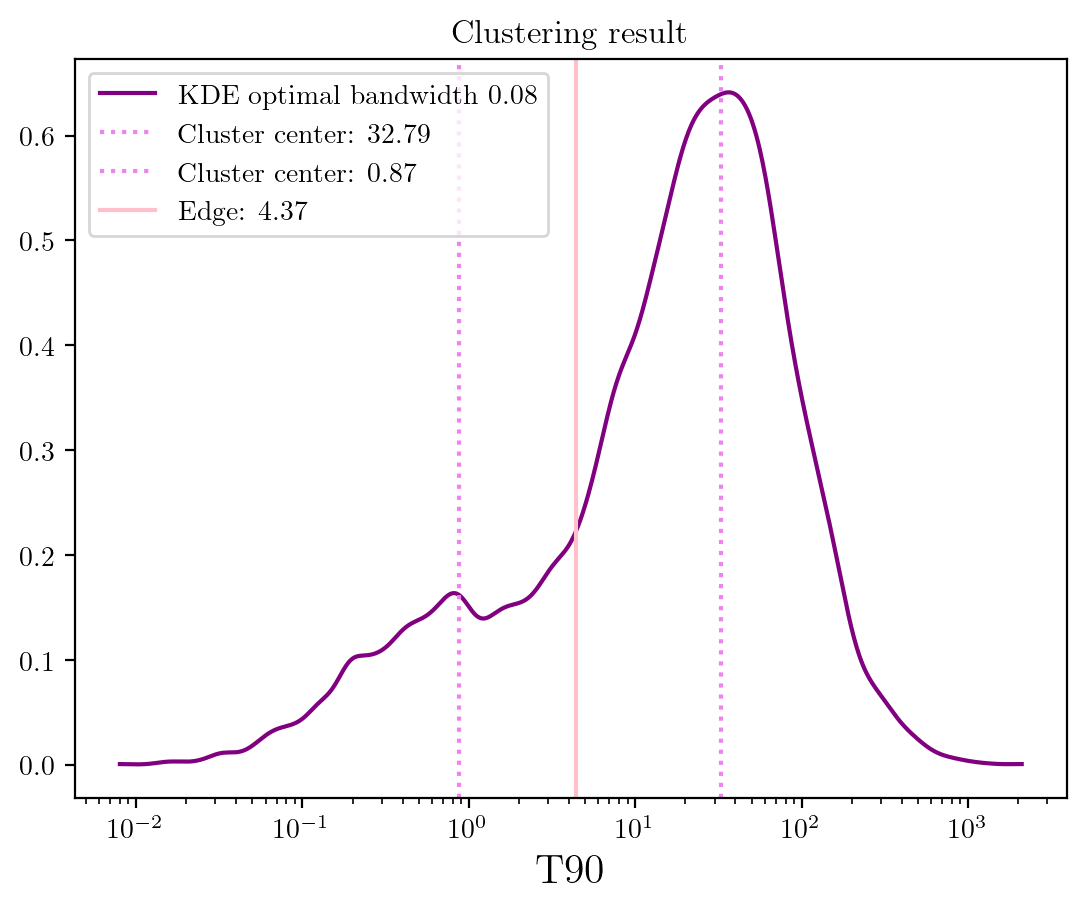

In [199]:
clf = KMeans(n_clusters=2, n_init='auto')
clf.fit(T90_log[:, np.newaxis])
centers_km = clf.cluster_centers_  # Location of the clusters
labels_km = clf.predict(T90_log[:, np.newaxis])
#edge_km = (np.mean([max(T90_log[labels_km == 0]), min(T90_log[labels_km == 1])]))

#i have the feeling that computing the edge with the percentiles I am less "in balia" of the specific realization
edge_km = np.mean([
    np.percentile(T90_log[labels_km == 0], 90), 
    np.percentile(T90_log[labels_km == 1], 10)
])

colors = ['pink', 'violet']
plt.plot(10**xgrid, PDF_opt, label=f'KDE optimal bandwidth {w_opt:.2f}', color='purple')

for c in centers_km:
    cen = 10**c
    plt.axvline(cen, color=colors[1], ls='dotted', label=f'Cluster center: {cen[0]:.2f}')

plt.axvline(10**edge_km, color=colors[0], label=f'Edge: {10**edge_km:.2f}')

plt.xscale('log')
plt.xlabel('T90', fontsize=15)
plt.title('Clustering result')
plt.legend()
plt.show()

## MeanShift

In [200]:
b = estimate_bandwidth(T90_log[:, np.newaxis]) 
print(b)

0.5188651703575995


In [201]:
scaler = preprocessing.StandardScaler()
ms = MeanShift(bandwidth=b, 
               bin_seeding=True, 
               cluster_all=False)
ms.fit(scaler.fit_transform(T90_log[:, np.newaxis]))

labels_ms = ms.labels_
labels_unique = np.unique(labels_ms)
n_clusters = len(labels_unique[labels_unique >= 0])

centers_ms = ms.cluster_centers_
centers_original_ms = scaler.inverse_transform(centers_ms)

print(labels_unique)
print("number of estimated clusters :", n_clusters)

[-1  0  1]
number of estimated clusters : 2


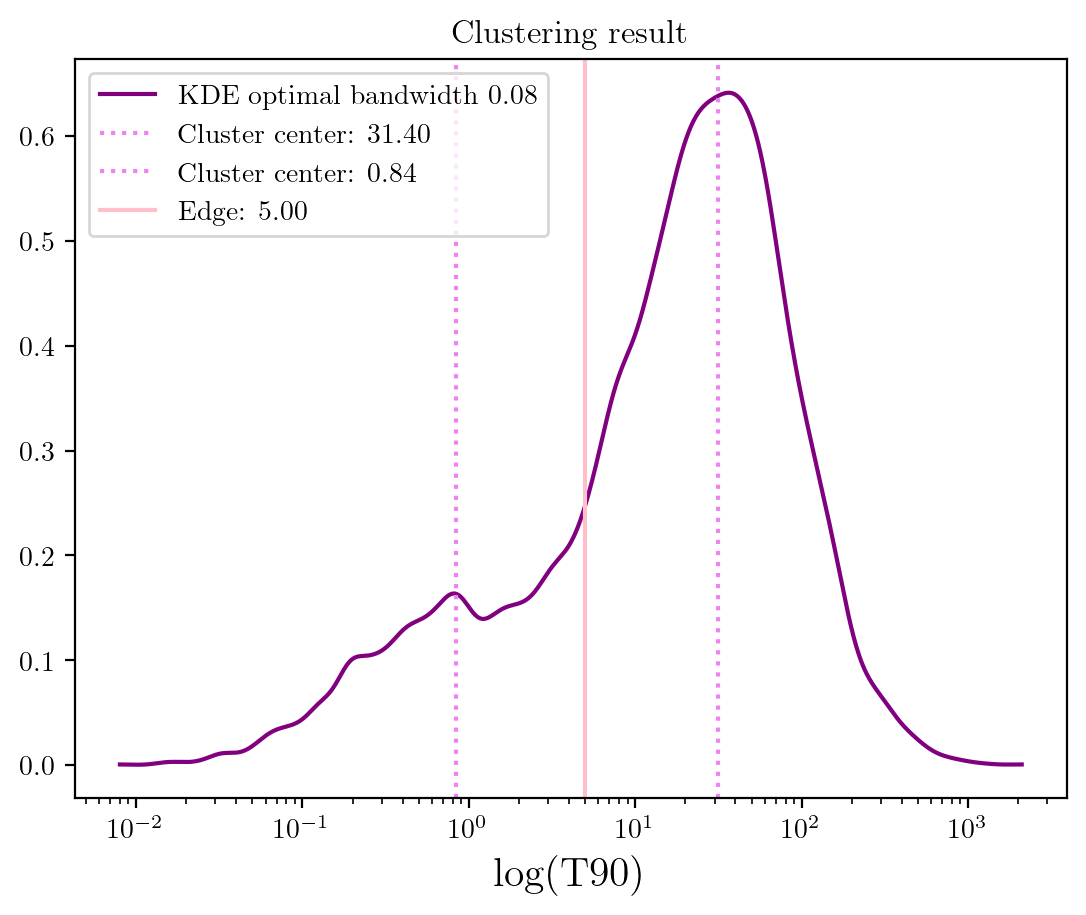

In [202]:
#edge_ms =  (np.mean([max(T90_log[labels_ms == 0]), min(T90_log[labels_ms == 1])]) )

#only bc I know that meanshift has estimated 2 clusters
edge_ms = np.mean([
    np.percentile(T90_log[labels_ms == 0], 90), 
    np.percentile(T90_log[labels_ms == 1], 10)
])
plt.plot(10**xgrid, PDF_opt, label=f'KDE optimal bandwidth {w_opt:.2f}',  color='purple')
for c in centers_original_ms:
    cen = 10**c
    plt.axvline(cen, color=colors[1], ls='dotted', label=f'Cluster center: {cen[0]:.2f}')
plt.axvline(10**edge_ms, color=colors[0], label=f'Edge: {10**edge_ms:.2f}')

plt.xscale('log')
plt.xlabel('log(T90)',fontsize=15)
plt.title('Clustering result')
plt.legend()
plt.show()

Result very close to before!

## RedShift

In [159]:
redshift = np.array(df_subset['redshift'][(df_subset['redshift'] > 0)])
np.log(max(redshift))

2.3978952727983707

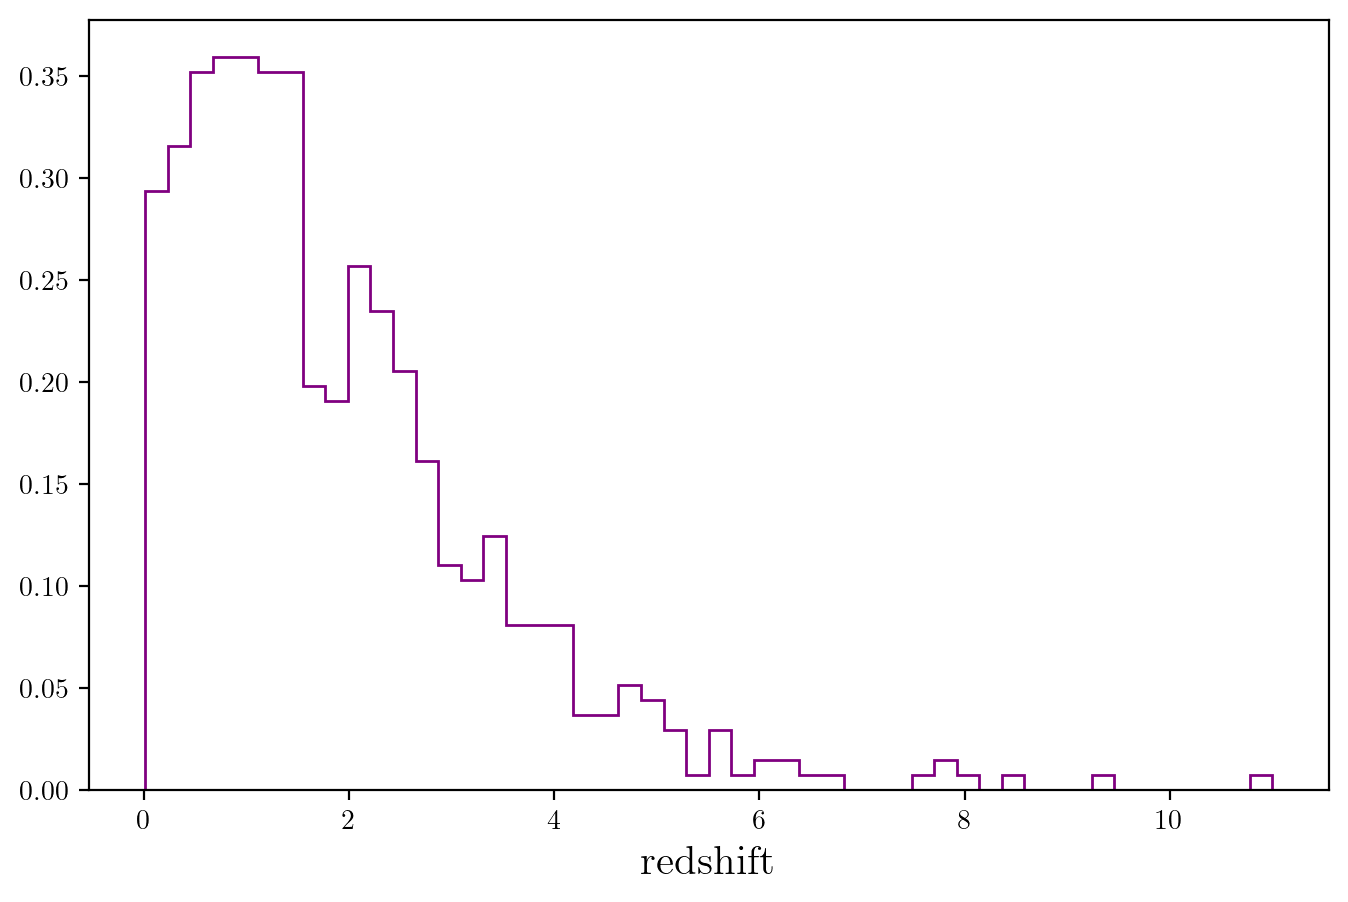

In [164]:
fig = plt.figure(figsize=(8, 5))
plt.hist(redshift, bins=50, density=True, histtype='step', color='purple')
plt.xlabel('redshift',fontsize=15)
plt.show()

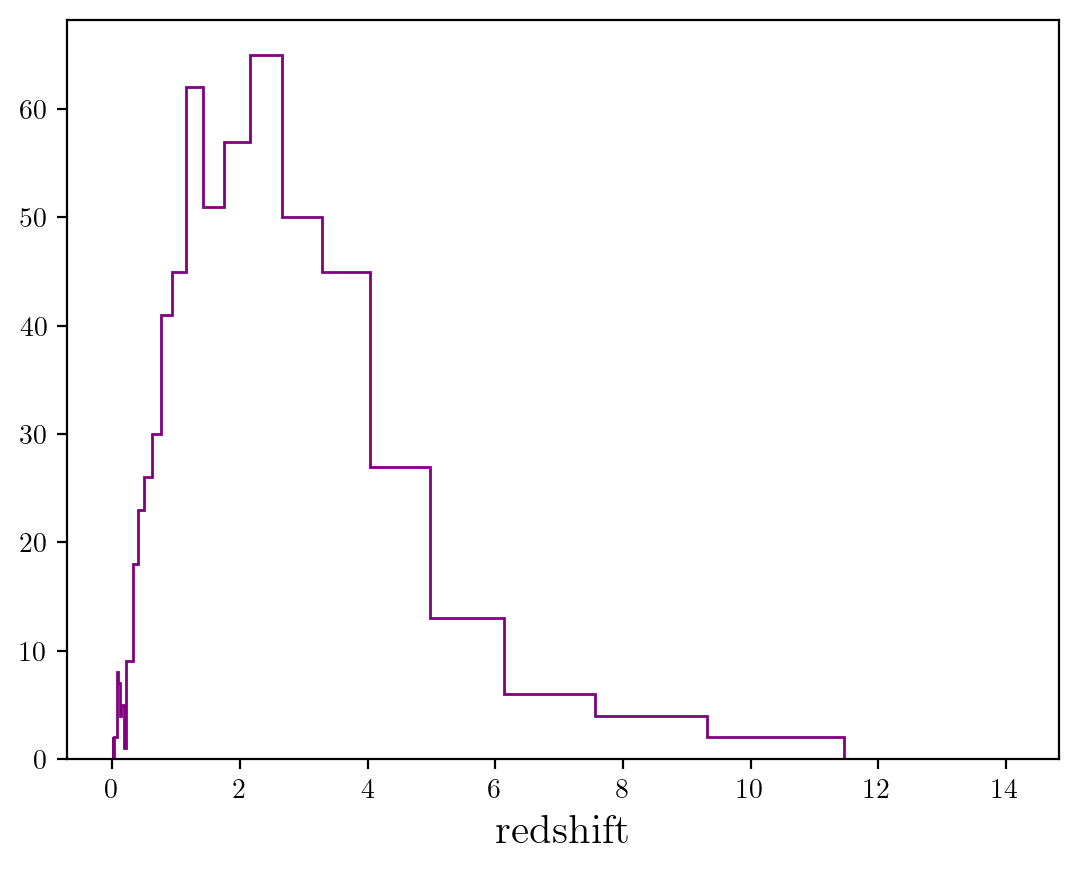

In [161]:
plt.hist(redshift[redshift>0], bins=np.logspace(-6,1.15,80), histtype='step', color='purple')
plt.xlabel('redshift',fontsize=15)
plt.show()

In [115]:
#try to searck for the optimal bandwidth kde

### KDE with cross validation for choosing bandwidth

0.495


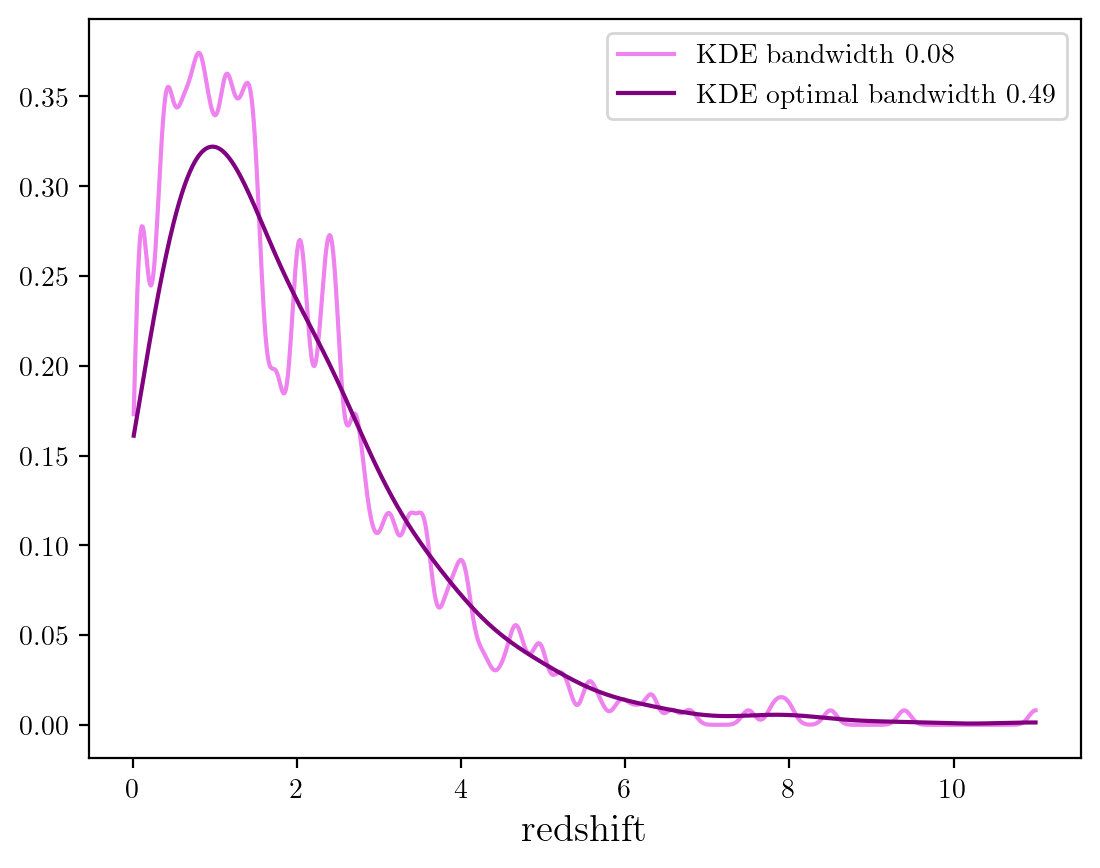

In [163]:
bwrange = np.linspace(0.0001,1.0, 100) 

K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) # Try each bandwidth with K-folds
grid.fit(redshift[:, np.newaxis]) #Fit the histogram data that we started the lecture with.
w_opt = grid.best_params_['bandwidth']
print(w_opt)

w=0.08
xgrid=np.linspace(redshift.min(), redshift.max(), 1000)

PDFtophat = kde_sklearn(redshift,bandwidth=w,kernel="gaussian")
plt.plot(xgrid,PDFtophat, label=f'KDE bandwidth {w}', color='violet')

PDFtophat = kde_sklearn(redshift,bandwidth=w_opt,kernel="gaussian")
plt.plot(xgrid,PDFtophat, label=f'KDE optimal bandwidth {w_opt:.2f}', color='purple')

plt.xlabel('redshift', fontsize=14)

plt.legend()
plt.show()

## T90 vs Redshift

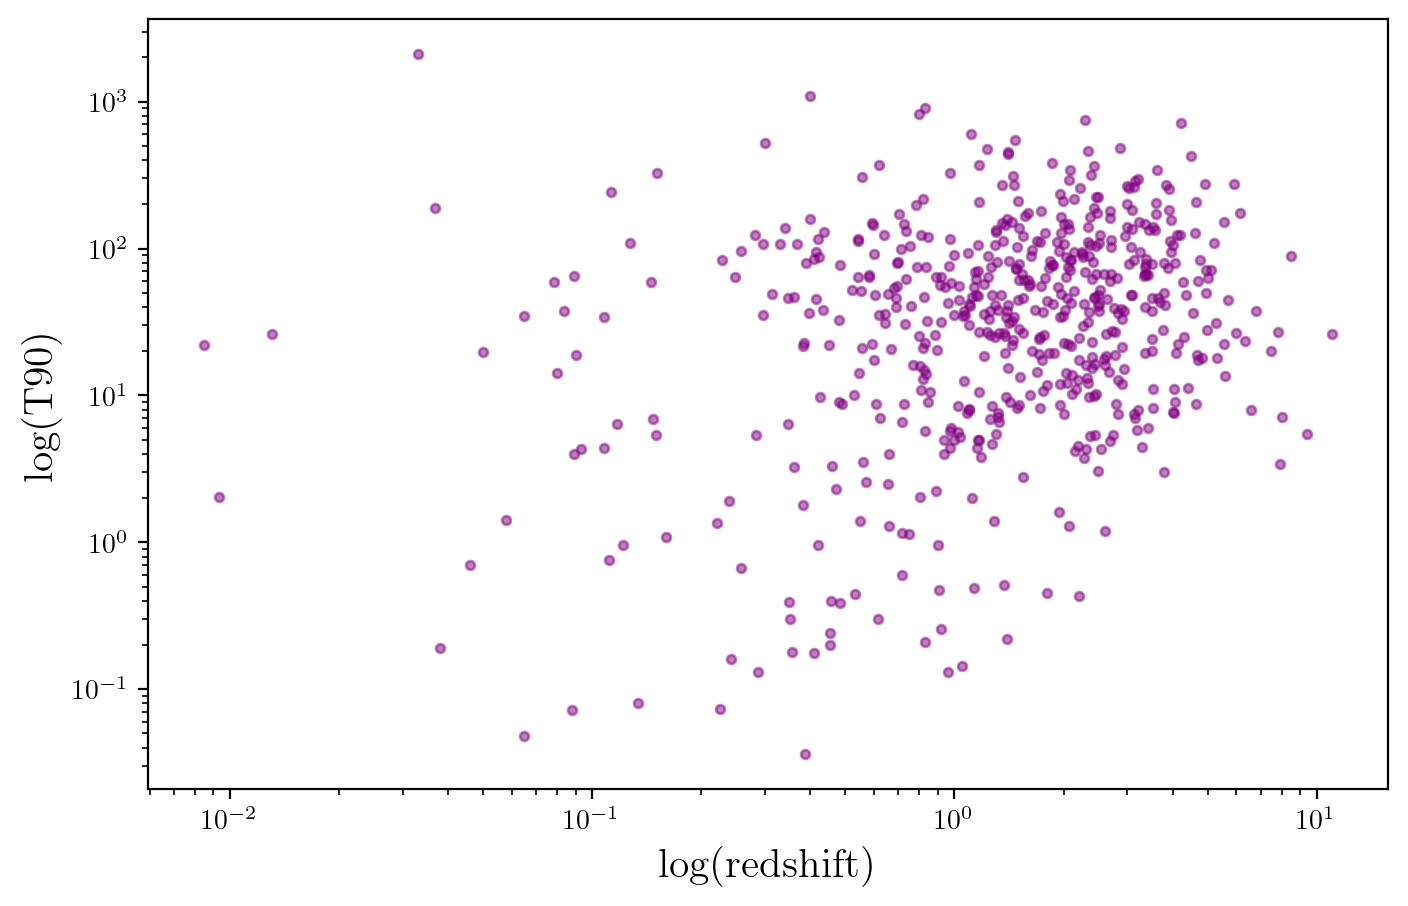

In [165]:
T90_new = np.array(df_subset['T90'][(df_subset['T90'] > 0) & (df_subset['redshift'] > 0)])
redshift_new = np.array(df_subset['redshift'][(df_subset['T90'] > 0) & (df_subset['redshift'] > 0)])

fig = plt.figure(figsize=(8, 5))
plt.scatter(redshift_new, T90_new, alpha=0.5, s=10, color='purple')

plt.xlabel('log(redshift)',fontsize=15)
plt.ylabel('log(T90)',fontsize=15)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [130]:
#try clustering on this last plot

## K means with 2 clusters

In [190]:
rt = np.column_stack((np.log(redshift_new), np.log(T90_new)))
print(rt.shape)

(576, 2)


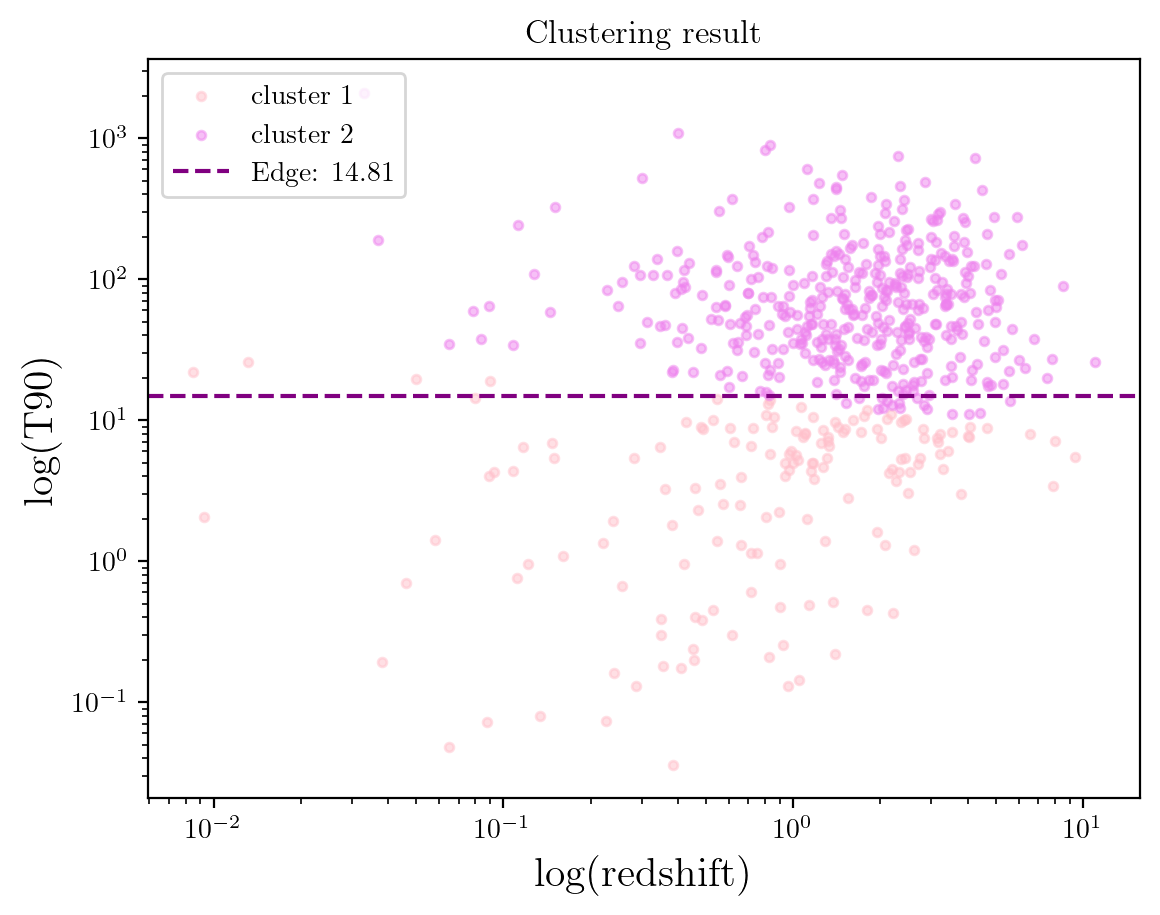

In [208]:
clf = KMeans(n_clusters=2,n_init='auto')
clf.fit(rt)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(rt)

colors = ['pink', 'violet']

for i in range(2):
    plt.scatter(redshift_new[labels==i], T90_new[labels==i], 
                color=colors[i],alpha=0.5, s=10, label=f'cluster {i+1}')


edge = np.mean([
    np.percentile(T90_new[labels == 0], 90), 
    np.percentile(T90_new[labels == 1], 10)
])
plt.axhline(y=edge, color='purple', linestyle='--', label=f'Edge: {edge:.2f}')


plt.xlabel('log(redshift)',fontsize=15)
plt.ylabel('log(T90)',fontsize=15)
plt.yscale('log')
plt.xscale('log')
plt.title('Clustering result')
plt.legend(loc='upper left')
plt.show()

Adding the redshift as a feature, it seems that the algorithm still finds a division only (or almost only) in T90 and bring the limit between the two types of GRB from 5 to 14